Analysis of the burrito dataset including
* descriptive statistics
* taco shop ranking
* modeling of overall satisfaction as a function of individual burrito dimensions
* principal component analysis

### Imports

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import statsmodels.api as sm
import util

pd.options.display.max_columns=25
sns.set_style('white')

/Users/scott/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Load data

In [2]:
df, df_shops, df_ingredients = util.load_burritos()
df.tail()

,Location,Burrito,Date,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,overall,Rec,Reviewer,Notes
346,rigoberto's taco shop,california,9/5/2017,6.85,3.5,NaN,NaN,22.2,22.5,0.89,3.0,4.5,4.0,4.0,4.5,3.0,4.0,4.0,3.5,4.25,NaN,sage,NaN
347,taco stand,california,12/29/2017,7.89,4.0,NaN,NaN,19.0,23.0,0.80,4.0,3.0,4.0,4.0,3.0,4.0,3.5,4.3,4.5,4.20,NaN,scott,NaN
348,taco stand,california,12/29/2017,7.89,5.0,NaN,NaN,20.0,21.5,0.74,5.0,5.0,5.0,5.0,4.0,4.0,5.0,5.0,3.0,4.50,NaN,ben s,NaN
349,lolita's taco shop,california,1/2/2018,7.25,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,5.0,5.0,3.0,3.0,4.0,5.0,3.50,Y,ben s,NaN
350,los tacos 2,local,1/12/2018,8.50,4.0,NaN,NaN,21.0,23.5,0.92,4.0,4.0,3.0,3.5,1.0,2.0,3.0,3.0,1.0,3.00,N,scott,NaN


### Dataset totals

In [3]:
print('Number of burritos:', df.shape[0])
print('Number of restaurants:', df.Location.nunique())
print('Number of reviewers:', df.Reviewer.nunique())
print('Total cost: ${:.2f}'.format(df.Cost.sum()))

Number of burritos: 351
Number of restaurants: 78
Number of reviewers: 69
Total cost: $2417.87


### Distribution of burrito types

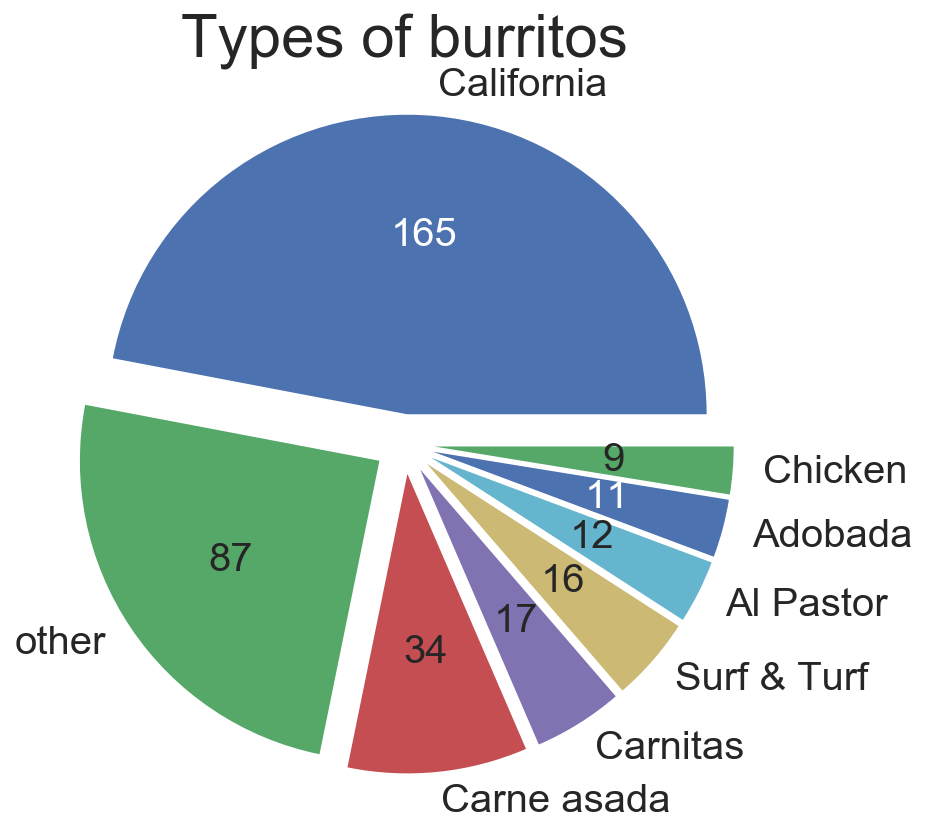

In [4]:
# Determine number of each type of burrito
df['Burrito_type'] = util.burritotypes(df.Burrito)
N_ratings_by_burritotype = df['Burrito_type'].value_counts()

# Pie chart
plt.figure(figsize=(8,8))
ax = plt.axes([0.1, 0.1, 0.65, 0.65])
patches, texts, autotexts = plt.pie(N_ratings_by_burritotype.values, explode=[.1]*len(N_ratings_by_burritotype),
                                    labels=N_ratings_by_burritotype.keys(), autopct=lambda p: '{:.0f}'.format(p * np.sum(N_ratings_by_burritotype.values) / 100), shadow=False, startangle=0)
plt.title('Types of burritos',size=30)

# Edit pie chart text labels
for t in texts:
    t.set_size(20)
for t in autotexts:
    t.set_size(20)
autotexts[0].set_color('w')
autotexts[6].set_color('w')

# Top taco shops in each burrito dimension

In [5]:
# Determine average rating for each feature for each taco shop
df_ratings = df[['Location','overall','Volume','Tortilla','Temp','Meat','Fillings',
                 'Meat:filling', 'Uniformity', 'Salsa', 'Synergy','Wrap']]
mean_ratings_by_shop = df_ratings.groupby('Location').mean()
mean_ratings_by_shop['N'] = df['Location'].value_counts()

# Limit to taco shops with a minimum number of ratings
min_ratings = 5
mean_ratings_by_shop = mean_ratings_by_shop[mean_ratings_by_shop['N'] >= min_ratings]

# Compute ranking for each taco shop
shop_rankings = mean_ratings_by_shop.rank(ascending=0)
shop_rankings = shop_rankings.drop('N', axis=1)

# Make dataframe of the top taco shops in each dimension
dims = shop_rankings.keys()
max_rank = 5
rank_dfs = {}

for i, dim in enumerate(dims):
    rank_dict = {'shop':[0]*max_rank, 'rank':[0]*max_rank, 'average':[0]*max_rank}
    rank_sort = shop_rankings[dim].sort_values()[:max_rank]
    for j, shop in enumerate(rank_sort.keys()):
        rank_dict['shop'][j] = shop
        rank_dict['rank'][j] = int(rank_sort[shop])
        rank_dict['average'][j] = np.round(mean_ratings_by_shop[dim][shop],2)
    rank_dfs[dim] = pd.DataFrame.from_dict(rank_dict)
    rank_dfs[dim] = rank_dfs[dim].set_index('rank')
    rank_dfs[dim] = rank_dfs[dim][['shop','average']]

In [6]:
# Display best taco shops in each dimension
for dim in dims:
    print('\n\nRANKINGS FOR:',dim,'rating')
    print(rank_dfs[dim])



RANKINGS FOR: overall rating
                          shop  average
rank                                   
1      valentines mexican food     4.31
2          california burritos     4.15
3                   taco stand     4.13
4     cancun mexican & seafood     4.10
5                    los tacos     4.09


RANKINGS FOR: Volume rating
                        shop  average
rank                                 
1           lupe's taco shop     1.09
2      rigoberto's taco shop     0.91
3           vallarta express     0.90
4                  los tacos     0.83
5     lucha libre north park     0.83


RANKINGS FOR: Tortilla rating
                          shop  average
rank                                   
1      valentines mexican food     4.06
2     cancun mexican & seafood     4.05
3                  los tacos 2     3.90
4          california burritos     3.88
5                   taco stand     3.78


RANKINGS FOR: Temp rating
                            shop  average
rank       

# Linear model: predicting overall satisfaction from burrito dimensions
* Note that if volume is included as a dimension, it has a significant positive coefficient, but it limits the data set size from 310 burritos to 212 burritos.

In [7]:
# Define predictors of the model
m_lm = ['Hunger','Tortilla','Temp','Meat','Fillings','Meat:filling',
        'Uniformity','Salsa','Wrap','Cost']

# Remove incomplete data 
dffull = df[np.hstack((m_lm,'overall'))].dropna()

# Run model and display results
X = sm.add_constant(dffull[m_lm])
y = dffull['overall']
my_glm = sm.GLM(y,X)
res = my_glm.fit()
print('Explained variance: {:.1f}%'.format(100*(1 - np.var(res.resid_pearson) / np.var(y))))
print(res.summary())

Explained variance: 71.2%
                 Generalized Linear Model Regression Results                  
Dep. Variable:                overall   No. Observations:                  310
Model:                            GLM   Df Residuals:                      299
Model Family:                Gaussian   Df Model:                           10
Link Function:               identity   Scale:                  0.143182200072
Method:                          IRLS   Log-Likelihood:                -133.01
Date:                Sat, 13 Jan 2018   Deviance:                       42.811
Time:                        08:24:03   Pearson chi2:                     42.8
No. Iterations:                     2                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.4362      0.239     -1.826      0.068      -0.904       0.032
Hunger           0.0

### Visualize model coefficients

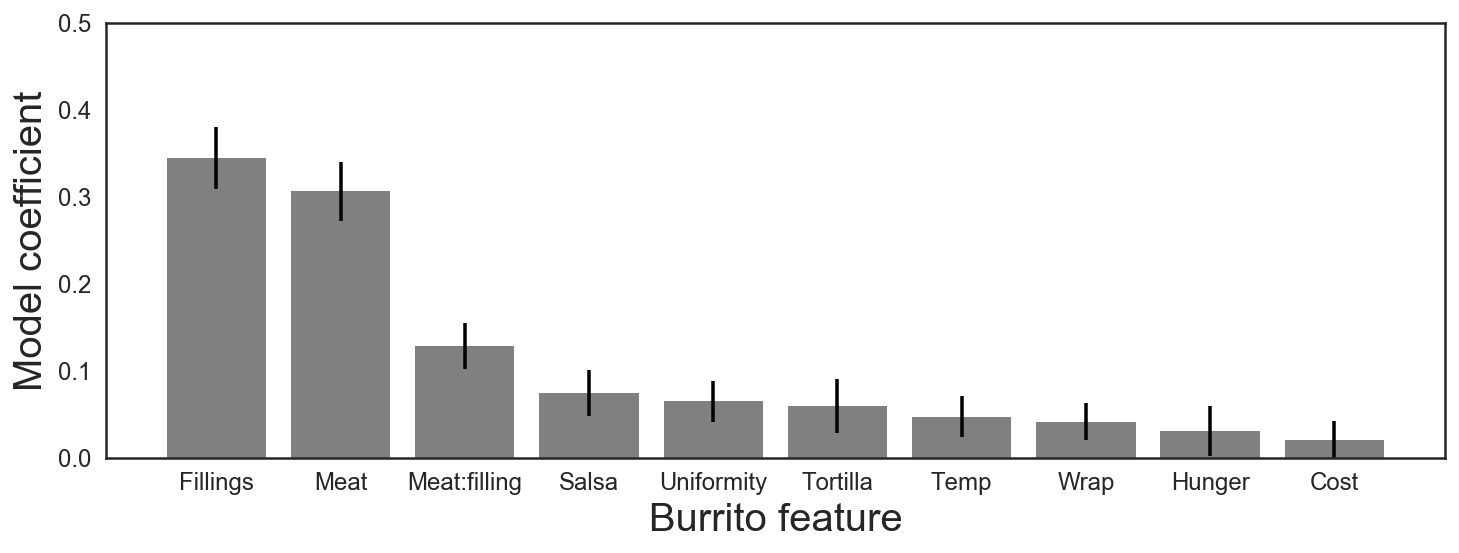

In [8]:
newidx = np.argsort(-res.params.values)
temp = np.arange(len(newidx))
newidx = np.delete(newidx,temp[newidx==0])

plt.figure(figsize=(12,4))
plt.bar(np.arange(len(newidx)), res.params[newidx].values, color='.5',yerr=res.bse[newidx].values)
plt.xticks(np.arange(len(newidx)),res.bse[newidx].keys(), size=12)
plt.yticks(np.arange(0,.6,.1), size=12)
plt.ylim((0,.5))
plt.xlabel('Burrito feature', size=20)
plt.ylabel('Model coefficient', size=20)

# Burrito dimension distributions

Average burrito cost:  $ 6.97


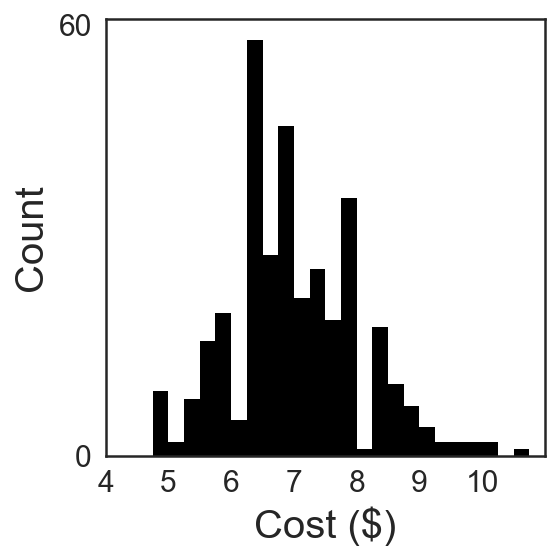

In [9]:
# how much to burritos cost?
plt.figure(figsize=(4,4))
n, _, _ = plt.hist(df.Cost.dropna(),np.arange(4,11.25,.25),color='k')
plt.xlabel('Cost ($)',size=20)
plt.xticks(np.arange(4,11,1),size=15)
plt.xlim((4,11))
plt.ylabel('Count',size=20)
plt.yticks((0,int(np.ceil(np.max(n) / 5.)) * 5),size=15)
plt.tight_layout()

print('Average burrito cost:  $', np.round(np.nanmean(df.Cost),2))

Average burrito volume:   0.79 liters


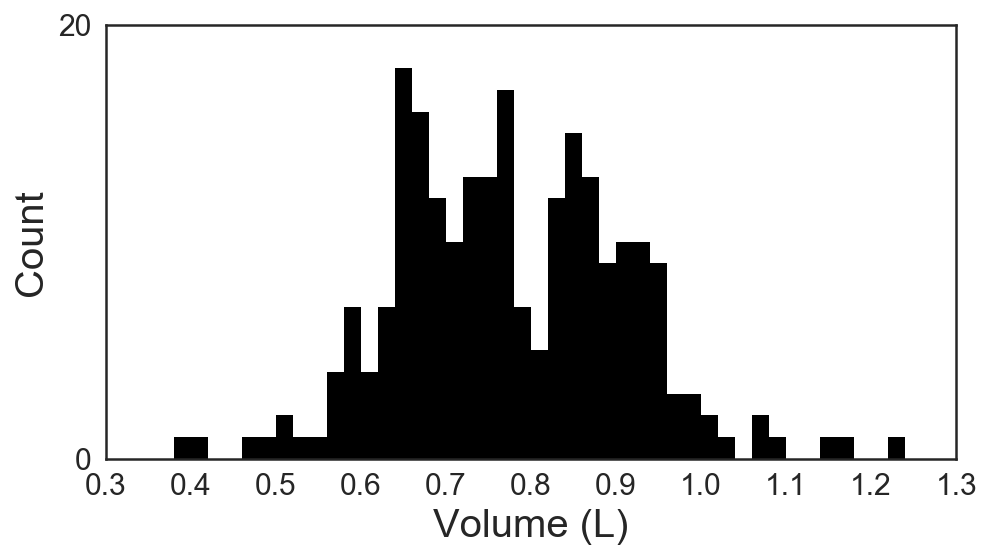

In [10]:
# How big are burritos?
plt.figure(figsize=(7,4))
n, _, _ = plt.hist(df.Volume.dropna(),np.arange(0.3,1.3,.02),color='k')
plt.xlabel('Volume (L)',size=20)
plt.xticks(np.arange(0.3,1.4,.1),size=15)
plt.xlim((0.3,1.3))
plt.ylabel('Count',size=20)
plt.yticks((0,int(math.ceil(np.max(n) / 5.)) * 5),size=15)
plt.tight_layout()

print('Average burrito volume:  ', np.round(np.nanmean(df.Volume),2),'liters')

# Volumetric value (liters per $)

In [11]:
# Compute volumetric value for each taco shop
df_ratings['volume_value'] = df['Volume'] / df['Cost']

# Compute average volumetric value for each taco shop
value_by_shop = df_ratings[['Location','volume_value']].groupby('Location').mean()
value_by_shop['N'] = df['Location'].value_counts()

# Limit to taco shops with a minimum number of ratings
min_ratings = 4
value_by_shop = value_by_shop[value_by_shop['N'] >= min_ratings]

# Compute ranking of shops
shop_value_rankings = value_by_shop.rank(ascending=0)
shop_value_rankings = shop_value_rankings.drop('N', axis=1)
shop_value_rankings['value (L/$)'] = round(value_by_shop['volume_value'],3)

# Format dataframe
shop_value_rankings['volume_value'] = shop_value_rankings['volume_value'].values.astype(int)
shop_value_rankings.dropna(inplace=True)
shop_value_rankings.reset_index(inplace=True)
shop_value_rankings.rename(columns={'volume_value': 'ranking'}, inplace=True)
shop_value_rankings.sort_values('ranking', inplace=True)
shop_value_rankings.set_index('ranking',drop=True,inplace=True)
print(shop_value_rankings.head(10))

                           Location  value (L/$)
ranking                                         
1            el dorado mexican food        0.136
2             rigoberto's taco shop        0.135
3               california burritos        0.131
4             caliente mexican food        0.129
5                  lupe's taco shop        0.127
6        california burrito company        0.117
7              ortiz's taco shop #2        0.117
8                  vallarta express        0.114
9            lucha libre north park        0.113
10         cancun mexican & seafood        0.109


/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Principal component analysis

### Interpretation of first 2 principal components
1. All of the dimension weights are negative. This indicates that a negative component weight represents a better burrito across all dimensions (especially falvor synergy)
2. A burrito with a higher weight of this component is larger, but suffers from suboptimal temperature, wrap integrity, meat-to-filling ratio, and ingredient distribution.

In [12]:
# Determine features to use in computing prinicple components
dfpca = df[['Volume','Tortilla','Temp','Meat','Fillings','Meat:filling',
            'Uniformity','Salsa','Synergy','Wrap']]

# Replace NaN with mean value (mainly applies to ratings missing Volume measurement)
dfpca = dfpca.fillna(dfpca.mean())

# Normalize each dimension
dfpca = (dfpca - dfpca.mean()) / dfpca.std()

# Apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(dfpca)

# Display principal components
pcinfo = {}
pcinfo['Burrito dimension'] = dfpca.keys()
pcinfo['Component 1 weight'] = pca.components_[0]
pcinfo['Component 2 weight'] = pca.components_[1]
print(pd.DataFrame.from_dict(pcinfo))
print('\nExplained variance from first 2 PCs:', pca.explained_variance_ratio_)

  Burrito dimension  Component 1 weight  Component 2 weight
0            Volume           -0.028922            0.558996
1          Tortilla           -0.297974            0.031967
2              Temp           -0.186336           -0.172809
3              Meat           -0.405611            0.190061
4          Fillings           -0.418192            0.268495
5      Meat:filling           -0.342631           -0.298840
6        Uniformity           -0.296113           -0.366527
7             Salsa           -0.310321            0.081001
8           Synergy           -0.469265            0.146776
9              Wrap           -0.121086           -0.544677

Explained variance from first 2 PCs: [ 0.32010477  0.13426222]


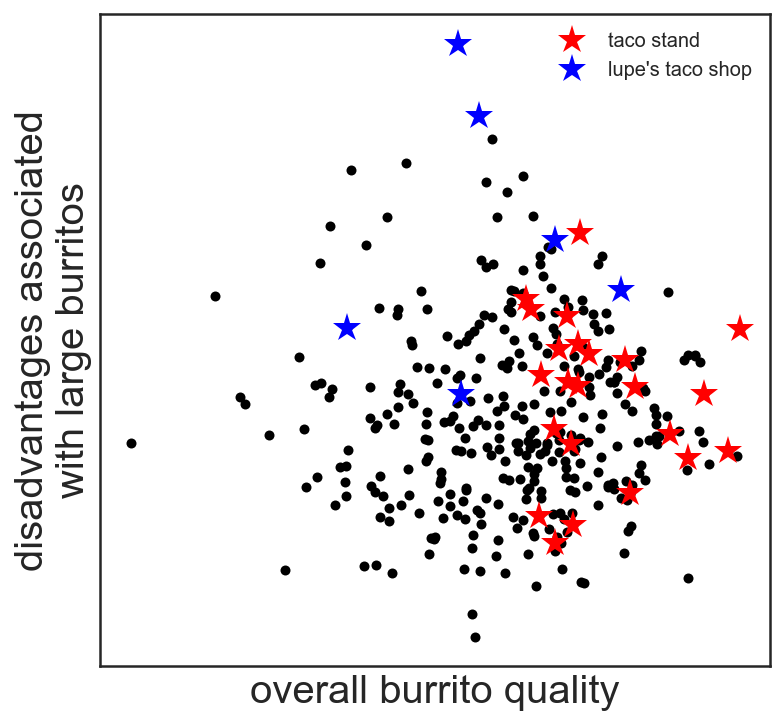

In [13]:
# Project data into PC space
dfpca_proj = np.dot(pca.components_,dfpca.T)

# Plot each burrito in PC space
plt.figure(figsize=(6,6))
plt.plot(-dfpca_proj[0],dfpca_proj[1],'k.',ms=10)
plt.xlabel('overall burrito quality',size=20)
plt.ylabel('disadvantages associated\nwith large burritos', size=20)
plt.xticks([])
plt.yticks([])

# Plot some taco shops in separate colors
shops = ['taco stand',"lupe's taco shop"]
colors = ['r','b']
for i, s in enumerate(shops):
    burridx = np.argwhere(df.Location==s)
    plt.plot(-dfpca_proj[0][burridx],dfpca_proj[1][burridx],'*',color=colors[i],ms=15,label=s)
plt.legend()

### Correlations between burrito dimensions

(0, 13)

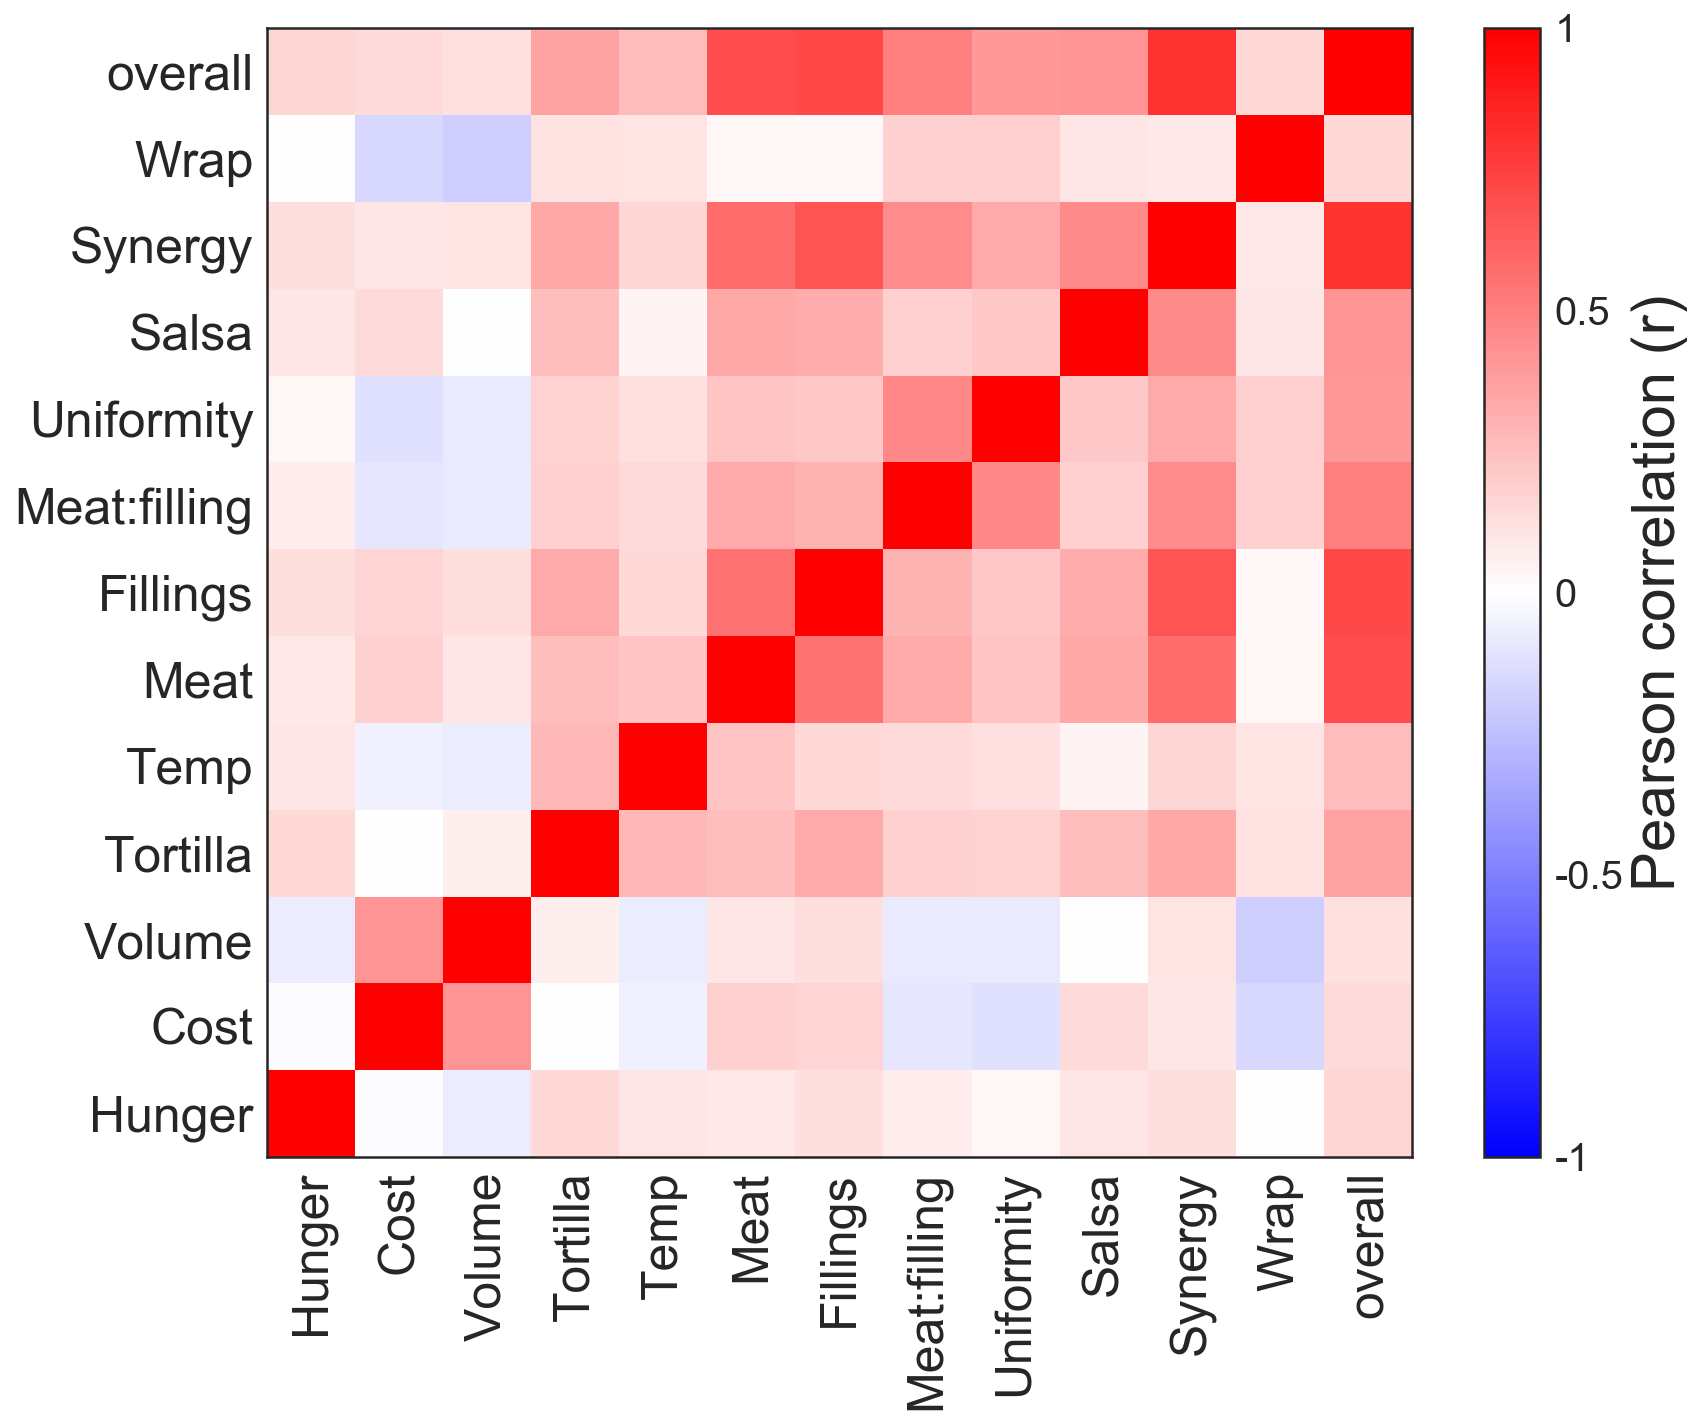

In [14]:
# Compute correlation matrix for a subset of the dataframe columns
m_corr = ['Hunger','Cost','Volume','Tortilla','Temp','Meat','Fillings','Meat:filling',
               'Uniformity','Salsa','Synergy','Wrap','overall']
dfcorr = df[m_corr].corr()

# Plot correlation matrix
M = len(m_corr)
from matplotlib import cm
clim1 = (-1,1)

plt.figure(figsize=(12,10))
cax = plt.pcolor(range(M+1), range(M+1), dfcorr, cmap=cm.bwr)
cbar = plt.colorbar(cax, ticks=(-1,-.5,0,.5,1))
cbar.ax.set_ylabel('Pearson correlation (r)', size=30)
plt.clim(clim1)
cbar.ax.set_yticklabels((-1,-.5,0,.5,1),size=20)
ax = plt.gca()
ax.set_yticks(np.arange(M)+.5)
ax.set_yticklabels(m_corr,size=25)
ax.set_xticks(np.arange(M)+.5)
ax.set_xticklabels(m_corr,size=25)
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.xlim((0,M))
plt.ylim((0,M))

Correlation between burrito cost and size: R^2 = 0.17
Correlation between meat and nonmeat flavors: R^2 = 0.31
Correlation between meat and nonmeat flavors: R^2 = 0.65


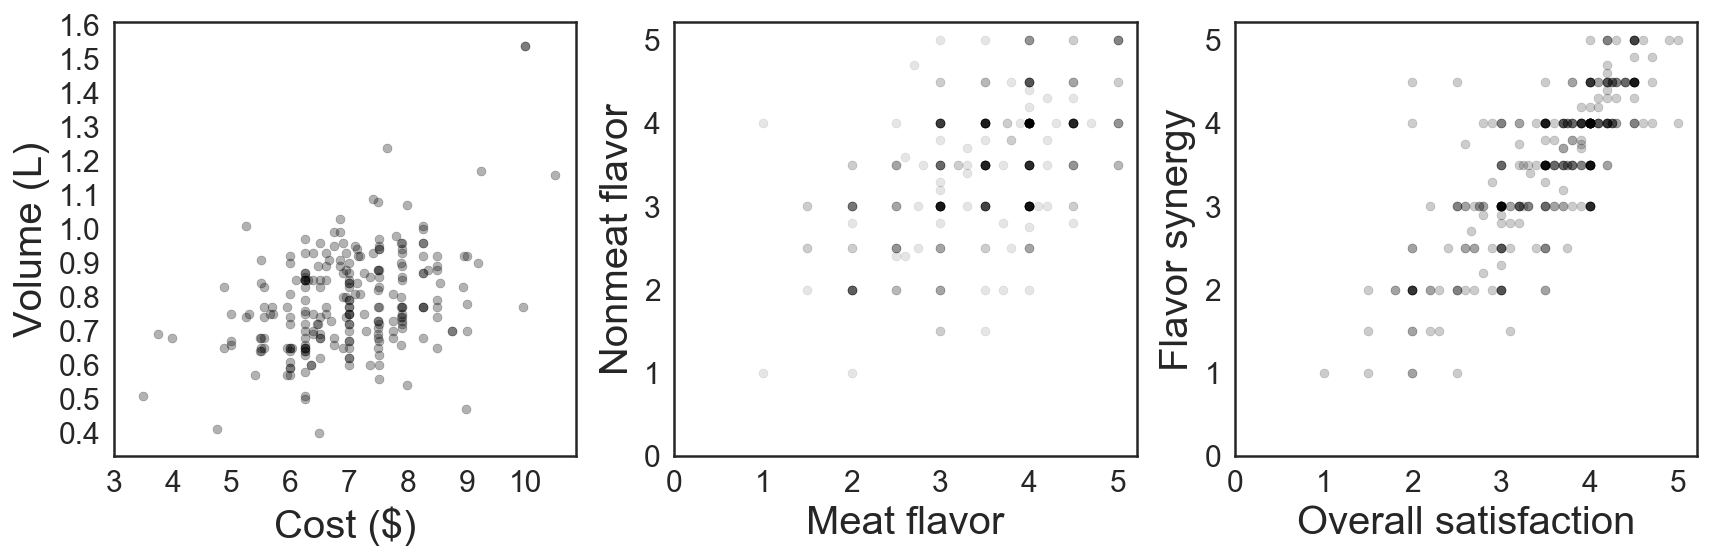

In [15]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
ax = plt.gca()
df.plot(kind='scatter',x='Cost',y='Volume',ax=ax,**{'s':20,'color':'k','alpha':.3})
plt.xlabel('Cost ($)',size=20)
plt.ylabel('Volume (L)',size=20)
plt.xticks(np.arange(3,11),size=15)
plt.yticks(np.arange(.4,1.7,.1),size=15)

plt.subplot(1,3,2)
ax = plt.gca()
df.plot(kind='scatter',x='Meat',y='Fillings',ax=ax,**{'s':20,'color':'k','alpha':.1})
plt.xlabel('Meat flavor',size=20)
plt.ylabel('Nonmeat flavor',size=20)
plt.xticks(np.arange(6),size=15)
plt.yticks(np.arange(6),size=15)

plt.subplot(1,3,3)
ax = plt.gca()
df.plot(kind='scatter',x='overall',y='Synergy',ax=ax,**{'s':20,'color':'k','alpha':.2})
plt.xlabel('Overall satisfaction',size=20)
plt.ylabel('Flavor synergy',size=20)
plt.xticks(np.arange(6),size=15)
plt.yticks(np.arange(6),size=15)

plt.tight_layout()
print('Correlation between burrito cost and size: R^2 =', np.round(df.corr()['Cost']['Volume']**2, 2))
print('Correlation between meat and nonmeat flavors: R^2 =', np.round(df.corr()['Meat']['Fillings']**2, 2))
print('Correlation between meat and nonmeat flavors: R^2 =', np.round(df.corr()['overall']['Synergy']**2, 2))